In [54]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

### Загрузка данных

In [57]:
DATA_DIR = "../data"
users = pd.read_csv(os.path.join(DATA_DIR, "users.csv"))
products = pd.read_csv(os.path.join(DATA_DIR, "products.csv"))
ratings = pd.read_csv(os.path.join(DATA_DIR, "ratings.csv"))

print(f"Продукты: {len(products)} записей")
print(f"Пользователи: {len(users)} записей")
print(f"Взаимодействия: {len(ratings)} записей")

product_types = products['type'].value_counts()
print('\n', product_types)

Продукты: 100 записей
Пользователи: 1000 записей
Взаимодействия: 10000 записей

 type
loan           28
credit_card    26
insurance      25
deposit        21
Name: count, dtype: int64


### Предобработка продуктов

In [61]:
from recommender.preprocessing import preprocess_products
product_features = preprocess_products(products)

print(f"Количество признаков: {product_features.shape[1] - 1}")
print("Первые 5 колонок:", product_features.columns.tolist()[:5])

Количество признаков: 6
Первые 5 колонок: ['product_id', 'interest_rate', 'term_months', 'min_income_required', 'type_deposit']


In [62]:
features_matrix = product_features.drop(columns=['product_id']).values
product_ids = product_features['product_id'].values

print(f"Размерность матрицы признаков: {features_matrix.shape}")

Размерность матрицы признаков: (100, 6)


In [63]:
# PCA для уменьшения размерности
pca = PCA(n_components=2, random_state=42)
features_pca = pca.fit_transform(features_matrix)

# t-SNE для нелинейной визуализации
perplexity = min(30, len(features_matrix) - 1)
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
features_tsne = tsne.fit_transform(features_matrix)

print(f"PCA выполнено. Объясненная дисперсия: {pca.explained_variance_ratio_.sum():.1%}")

PCA выполнено. Объясненная дисперсия: 57.0%


In [64]:
viz_df = pd.DataFrame({
    'product_id': product_ids,
    'type': products.set_index('product_id').loc[product_ids]['type'].values,
    'interest_rate': products.set_index('product_id').loc[product_ids]['interest_rate'].values,
    'term_months': products.set_index('product_id').loc[product_ids]['term_months'].values,
    'min_income': products.set_index('product_id').loc[product_ids]['min_income_required'].values,
    'pca_x': features_pca[:, 0],
    'pca_y': features_pca[:, 1],
    'tsne_x': features_tsne[:, 0],
    'tsne_y': features_tsne[:, 1]
})

# Добавляем популярность
product_popularity = ratings['product_id'].value_counts()
viz_df['popularity'] = viz_df['product_id'].map(product_popularity).fillna(0)

print(f"Колонки: {viz_df.columns.tolist()}")
print(f"Уникальные типы продуктов: {viz_df['type'].unique()}")

Колонки: ['product_id', 'type', 'interest_rate', 'term_months', 'min_income', 'pca_x', 'pca_y', 'tsne_x', 'tsne_y', 'popularity']
Уникальные типы продуктов: ['deposit' 'credit_card' 'loan' 'insurance']


### Визуализация PCA по типам продуктов

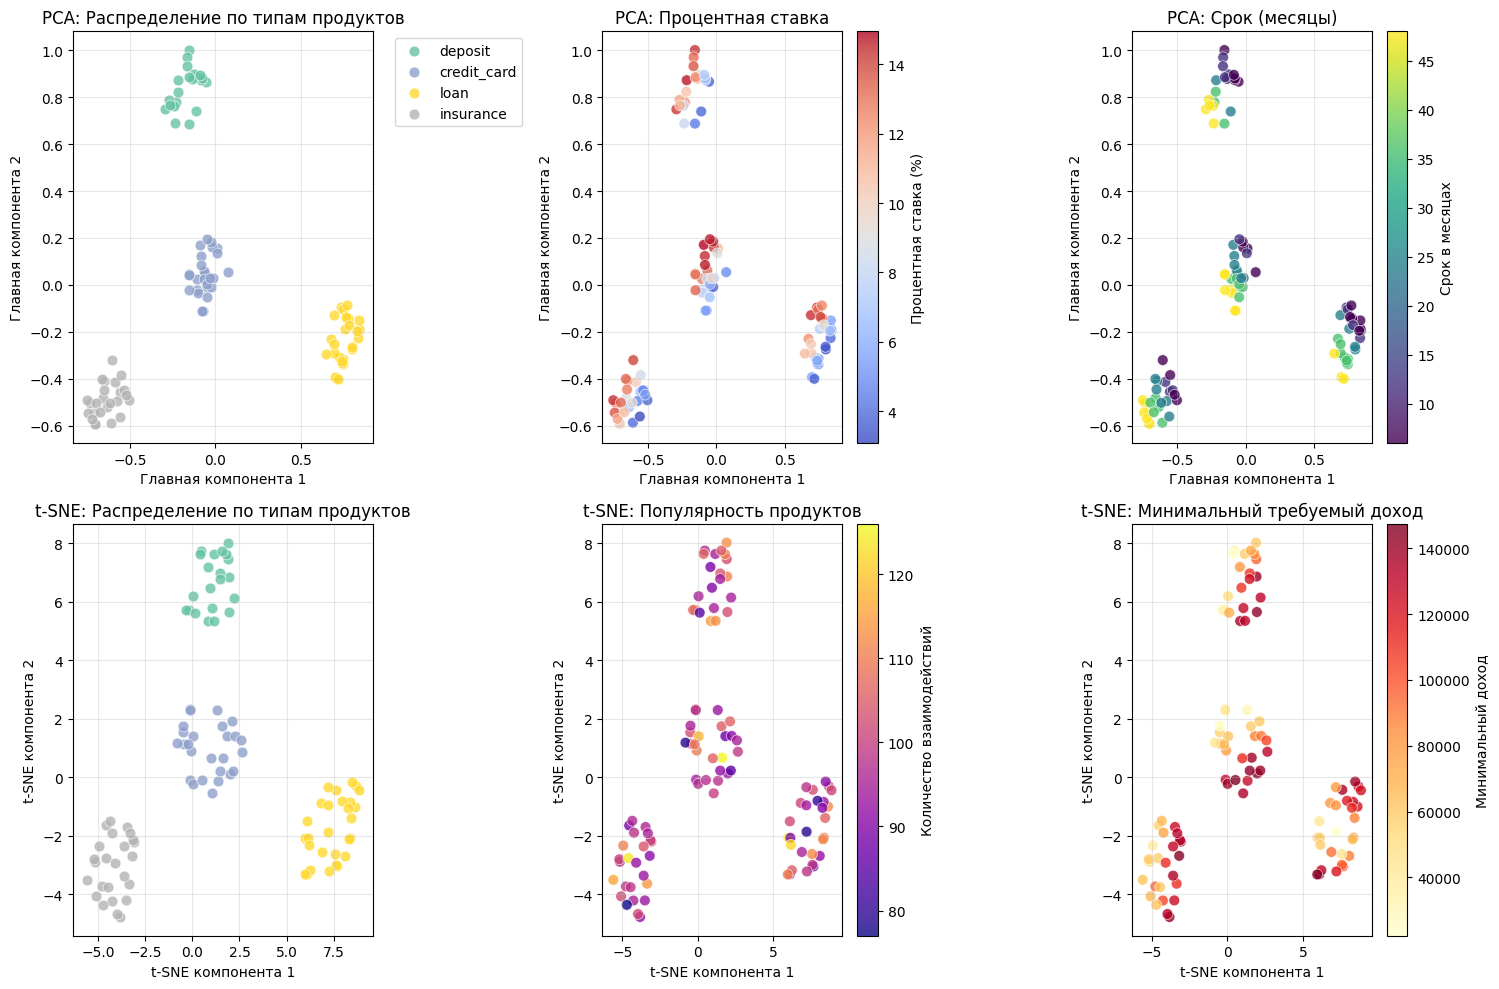

In [72]:
plt.figure(figsize=(15, 10))

# 1.1 PCA по типам продуктов
plt.subplot(2, 3, 1)
product_types = viz_df['type'].unique()
colors = plt.cm.Set2(np.linspace(0, 1, len(product_types)))

for i, p_type in enumerate(product_types):
    type_data = viz_df[viz_df['type'] == p_type]
    plt.scatter(type_data['pca_x'], type_data['pca_y'], 
                color=colors[i], label=p_type, 
                alpha=0.8, s=60, edgecolors='w', linewidth=0.5)

plt.title('PCA: Распределение по типам продуктов')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 1.2 PCA по процентной ставке
plt.subplot(2, 3, 2)
scatter = plt.scatter(viz_df['pca_x'], viz_df['pca_y'], 
                     c=viz_df['interest_rate'], cmap='coolwarm',
                     alpha=0.8, s=60, edgecolors='w', linewidth=0.5)

plt.title('PCA: Процентная ставка')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.grid(True, alpha=0.3)
plt.colorbar(scatter, label='Процентная ставка (%)')

# 1.3 PCA по сроку
plt.subplot(2, 3, 3)
scatter = plt.scatter(viz_df['pca_x'], viz_df['pca_y'], 
                     c=viz_df['term_months'], cmap='viridis',
                     alpha=0.8, s=60, edgecolors='w', linewidth=0.5)

plt.title('PCA: Срок (месяцы)')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.grid(True, alpha=0.3)
plt.colorbar(scatter, label='Срок в месяцах')

# 1.4 t-SNE по типам продуктов
plt.subplot(2, 3, 4)
for i, p_type in enumerate(product_types):
    type_data = viz_df[viz_df['type'] == p_type]
    plt.scatter(type_data['tsne_x'], type_data['tsne_y'], 
                color=colors[i], label=p_type, 
                alpha=0.8, s=60, edgecolors='w', linewidth=0.5)

plt.title('t-SNE: Распределение по типам продуктов')
plt.xlabel('t-SNE компонента 1')
plt.ylabel('t-SNE компонента 2')
plt.grid(True, alpha=0.3)

# 1.5 t-SNE по популярности
plt.subplot(2, 3, 5)
scatter = plt.scatter(viz_df['tsne_x'], viz_df['tsne_y'], 
                     c=viz_df['popularity'], cmap='plasma',
                     alpha=0.8, s=60, edgecolors='w', linewidth=0.5)

plt.title('t-SNE: Популярность продуктов')
plt.xlabel('t-SNE компонента 1')
plt.ylabel('t-SNE компонента 2')
plt.grid(True, alpha=0.3)
plt.colorbar(scatter, label='Количество взаимодействий')

# 1.6 t-SNE по минимальному доходу
plt.subplot(2, 3, 6)
scatter = plt.scatter(viz_df['tsne_x'], viz_df['tsne_y'], 
                     c=viz_df['min_income'], cmap='YlOrRd',
                     alpha=0.8, s=60, edgecolors='w', linewidth=0.5)

plt.title('t-SNE: Минимальный требуемый доход')
plt.xlabel('t-SNE компонента 1')
plt.ylabel('t-SNE компонента 2')
plt.grid(True, alpha=0.3)
plt.colorbar(scatter, label='Минимальный доход')

plt.tight_layout()
plt.show()

### Анализ кластеризации

In [73]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder

# Кодируем типы продуктов
le = LabelEncoder()
encoded_types = le.fit_transform(viz_df['type'])

# Вычисляем silhouette score
if len(set(encoded_types)) > 1:
    silhouette_pca = silhouette_score(features_pca, encoded_types)
    silhouette_tsne = silhouette_score(features_tsne, encoded_types)
    
    print(f"Silhouette score (PCA): {silhouette_pca:.3f}")
    print(f"Silhouette score (t-SNE): {silhouette_tsne:.3f}")
    
    # Интерпретация
    if silhouette_pca > 0.5:
        print("-> Отличная кластеризация по типам продуктов")
    elif silhouette_pca > 0.25:
        print("-> Умеренная кластеризация по типам продуктов")
    else:
        print("-> Слабая кластеризация по типам продуктов")
        
    print(f"-> t-SNE улучшает разделение в {silhouette_tsne/silhouette_pca:.1f} раз")

Silhouette score (PCA): 0.832
Silhouette score (t-SNE): 0.724
-> Отличная кластеризация по типам продуктов
-> t-SNE улучшает разделение в 0.9 раз


### Анализ корреляции с PCA компонентами

In [75]:
analysis_df = viz_df[['pca_x', 'pca_y', 'interest_rate', 'term_months', 'min_income', 'popularity']].copy()

# Вычисляем корреляцию
correlation_matrix = analysis_df.corr()

print("\nКорреляция с PCA компонентами:")

print("Признак              | Корреляция с PC1 | Корреляция с PC2")

features_to_check = ['interest_rate', 'term_months', 'min_income', 'popularity']
for feature in features_to_check:
    corr_pc1 = correlation_matrix.loc[feature, 'pca_x']
    corr_pc2 = correlation_matrix.loc[feature, 'pca_y']
    print(f"{feature:20} | {corr_pc1:16.3f} | {corr_pc2:16.3f}")


Корреляция с PCA компонентами:
Признак              | Корреляция с PC1 | Корреляция с PC2
interest_rate        |           -0.193 |            0.198
term_months          |           -0.198 |           -0.218
min_income           |            0.012 |           -0.151
popularity           |            0.030 |            0.087


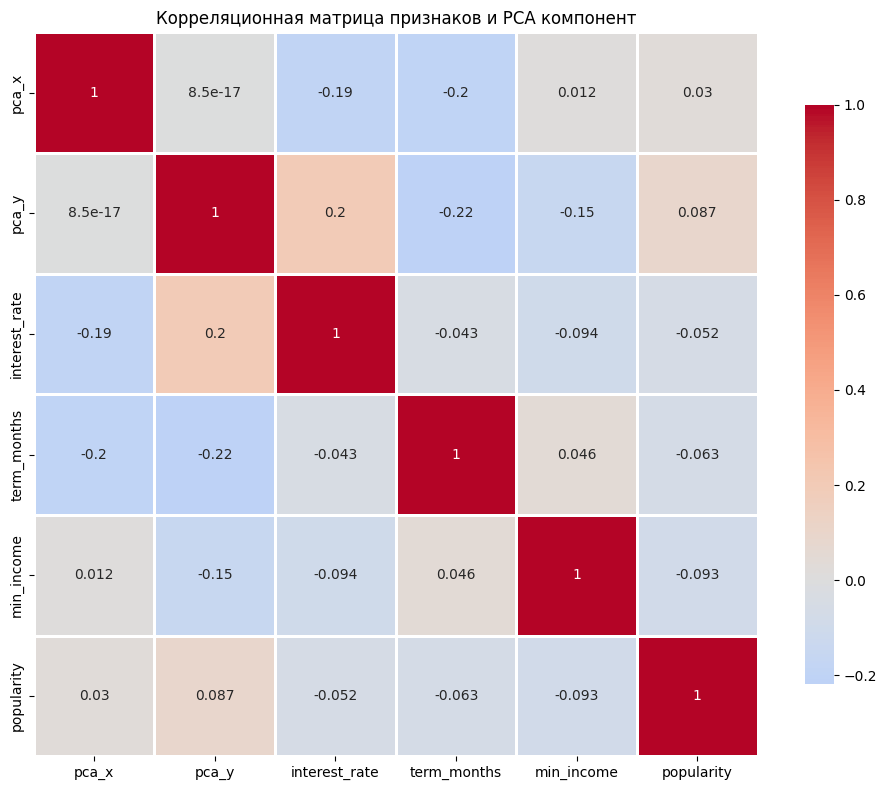

In [76]:
# Визуализация корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .8})
plt.title('Корреляционная матрица признаков и PCA компонент')
plt.tight_layout()
plt.show()

### Анализ важных признаков в PCA

In [51]:
feature_names = product_features.drop(columns=['product_id']).columns.tolist()
pca_components = pd.DataFrame(
    pca.components_.T[:, :2],  # Первые 2 компоненты
    index=feature_names,
    columns=['PC1', 'PC2']
)

print("\nТОП-10 самых важных признаков:")
print("="*40)

for component in ['PC1', 'PC2']:
    print(f"\n{component} (важность признаков):")
    top_features = pca_components[component].abs().sort_values(ascending=False).head(10)
    
    for i, (feat, val) in enumerate(top_features.items(), 1):
        sign = "+" if pca_components.loc[feat, component] > 0 else "-"
        print(f"  {i:2}. {sign} {feat}: {abs(val):.3f}")


ТОП-10 самых важных признаков:

PC1 (важность признаков):
   1. + type_loan: 0.777
   2. - type_insurance: 0.587
   3. - term_months: 0.143
   4. - type_deposit: 0.131
   5. - interest_rate: 0.114
   6. + min_income_required: 0.007

PC2 (важность признаков):
   1. + type_deposit: 0.763
   2. - type_insurance: 0.532
   3. - type_loan: 0.284
   4. - term_months: 0.171
   5. + interest_rate: 0.127
   6. - min_income_required: 0.094
